# Balanced validation

In [1]:
# Retina quality plots
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd

y_valid = pd.read_parquet('../../data/features_data/raw_subject_split/y_valid_balanced.parquet')['HepB']

y_valid.head()

1479948    False
3833834     True
1884337     True
3610431     True
2662499     True
Name: HepB, dtype: bool

In [3]:
cluster_sizes = pd.read_parquet('../../data/combined/clustered/final/Galson_2015a.parquet').groupby('Cluster_ID').size()

cluster_sizes.head()

Cluster_ID
0    27
1    20
2    18
3    11
4     8
dtype: int64

In [4]:
valid_cluster_sizes = cluster_sizes.loc[y_valid.index]

valid_cluster_sizes.head()

1479948    1
3833834    1
1884337    1
3610431    1
2662499    1
dtype: int64

## Validation

In [5]:
from fairseq.models.roberta import RobertaModel

def load_roberta(model, data, checkpoint='checkpoint_best.pt'):
    roberta = RobertaModel.from_pretrained(
        f'../../models/RoBERTa/{data}/subject_split_neg_subs/{model}/checkpoints/',
        checkpoint_file=checkpoint,
        data_name_or_path=f'../../../../../../data/RoBERTa/processed/{data}/train/subject_split_neg_subs/',
        user_dir='../../bin/fairseq_plugins/',
        bpe=None
    )
    roberta.eval() # disable dropout
    
    return roberta

In [6]:
from bin.evaluation import evaluate_classifier

import os
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, recall_score, roc_curve

def fpr(y_true, y_pred, sample_weight=None):
    return roc_curve(y_true, y_pred, sample_weight=sample_weight)[0][1]

METRICS = [
    ('F1', f1_score),
    ('Accuracy', accuracy_score),
    ('MCC', matthews_corrcoef),
    ('Recall', recall_score),
    ('FPR', fpr)
]

def eval_models(y_true, data_dir, models, metrics=METRICS, sample_weights=None):
    for model in models:
        predictions_path = f'../../data/RoBERTa/predictions/{data_dir}/{model}.npy'
        
        if not os.path.exists(predictions_path):
            continue
        
        print(model)
        print('-' * 40)
        preds = np.load(predictions_path)
        evaluate_classifier(y_true, preds.argmax(1), preds[:,1], metrics, sample_weights=sample_weights)
        
def models_from_dir(dir_path):
    return sorted([filename for filename in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, filename)) and not filename.startswith('.')])

### Heavy - non-weighted

In [7]:
heavy_models = models_from_dir('../../models/RoBERTa/mode_seq_heavy/subject_split_neg_subs/')
heavy_models

['02_small_pretrained_2000epochs', '03_frozen_small_pretrained_2000epochs']

02_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.765
Accuracy: 0.761
MCC: 0.521
Recall: 0.778
FPR: 0.257




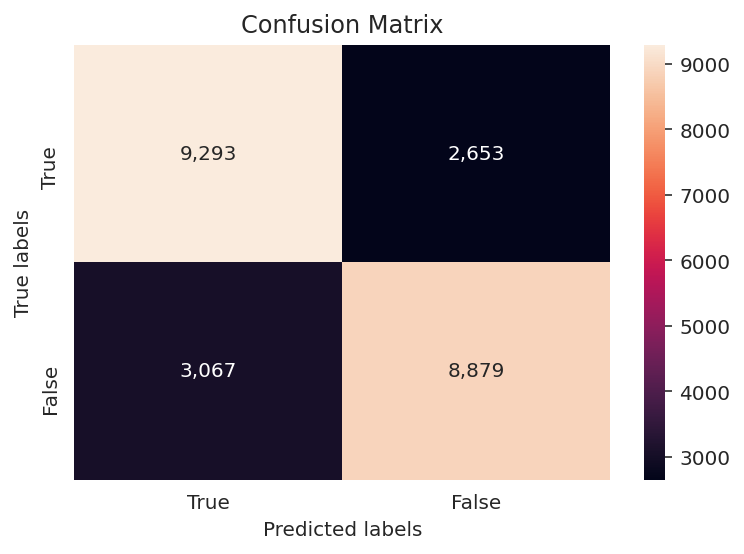

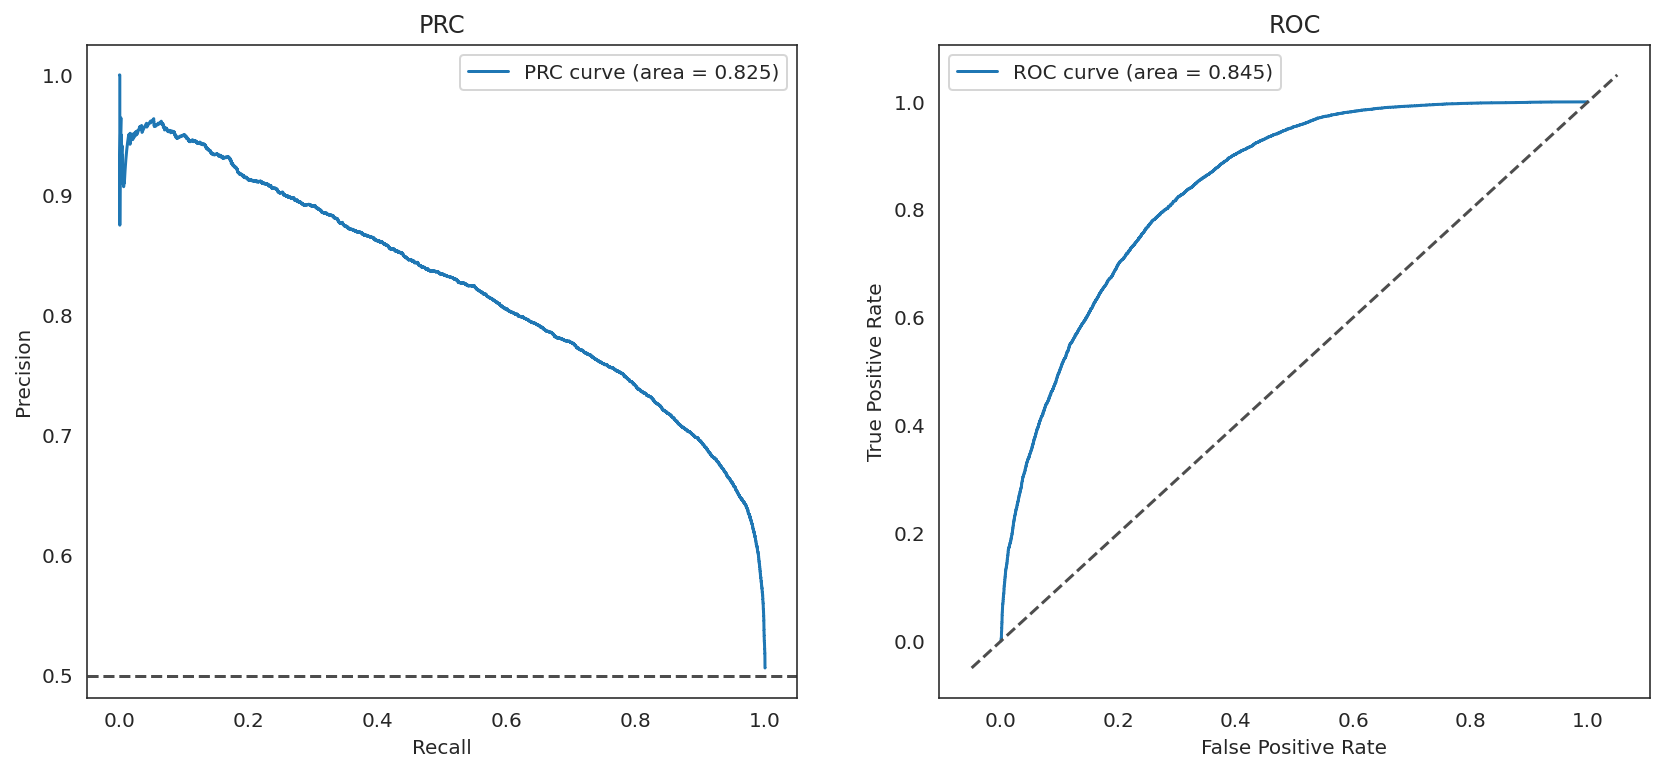

03_frozen_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.759
Accuracy: 0.731
MCC: 0.474
Recall: 0.847
FPR: 0.386




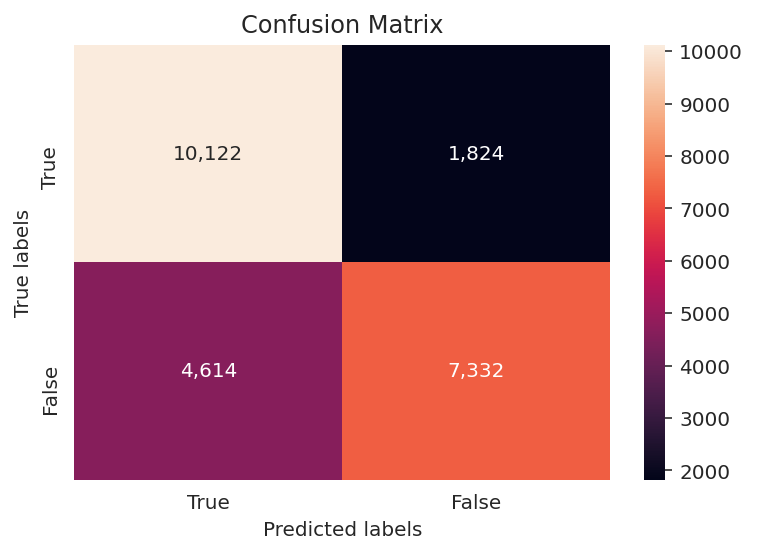

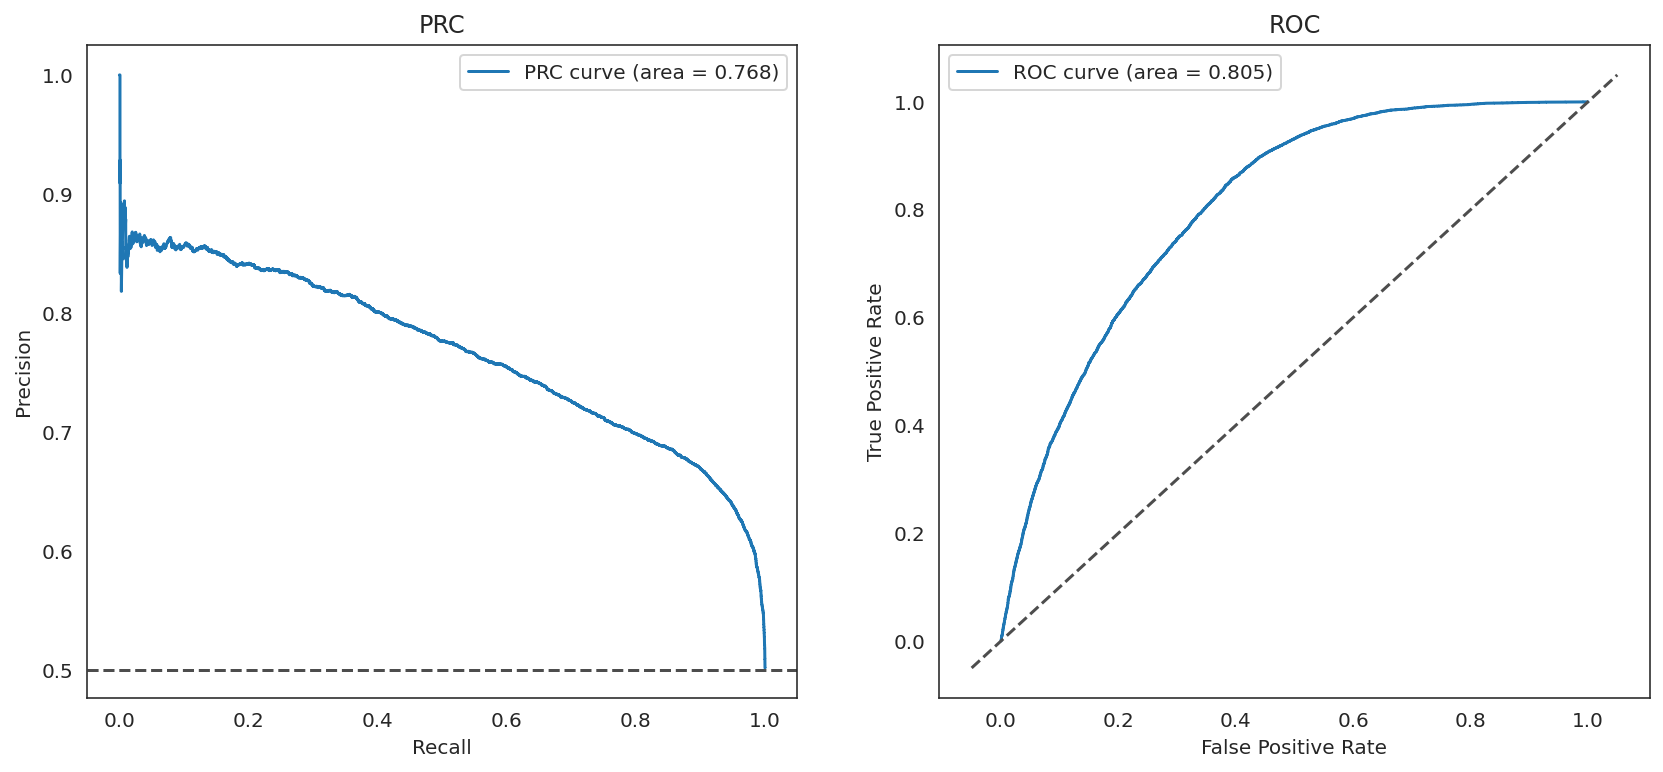

In [8]:
eval_models(y_valid, 'valid_balanced_heavy', heavy_models)

### Heavy - weighted

02_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.476
Accuracy: 0.632
MCC: 0.295
Recall: 0.760
FPR: 0.404




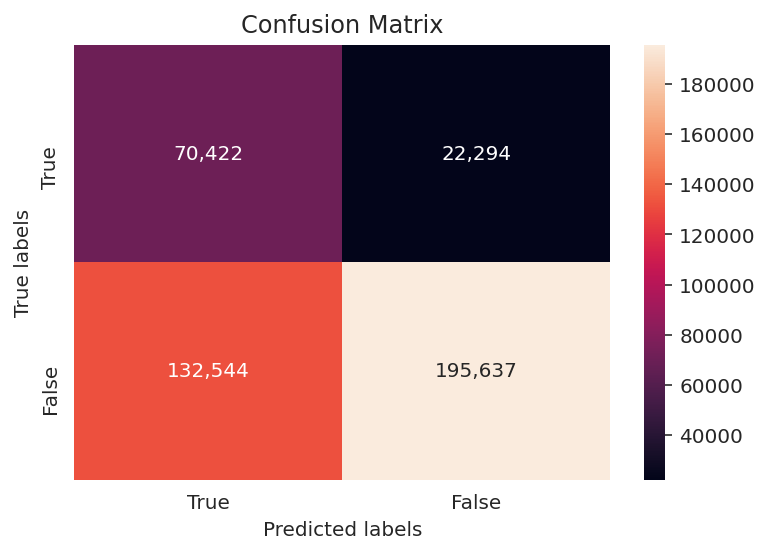

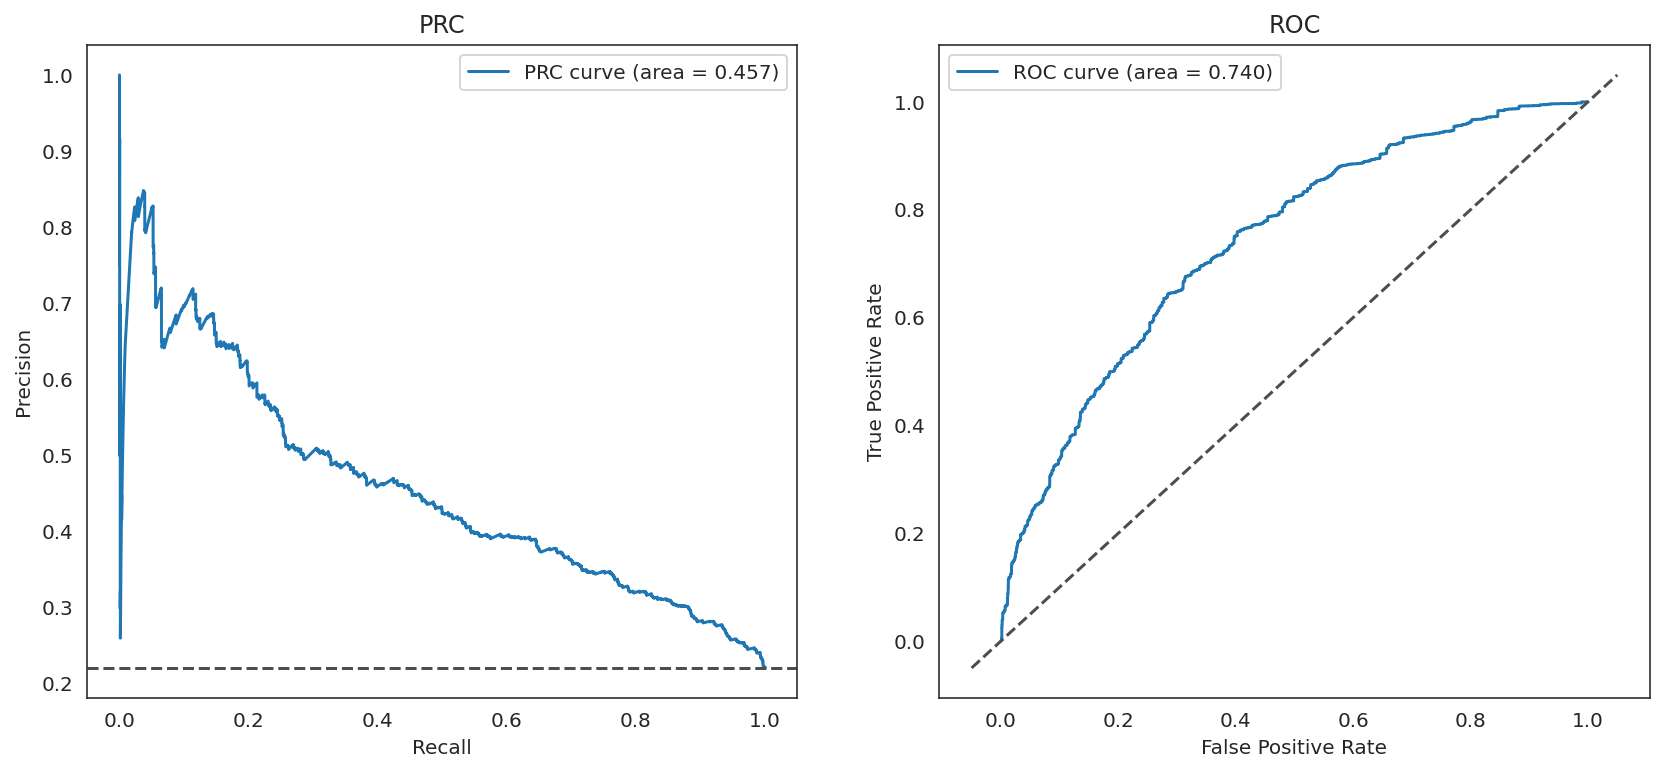

03_frozen_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.412
Accuracy: 0.481
MCC: 0.183
Recall: 0.825
FPR: 0.616




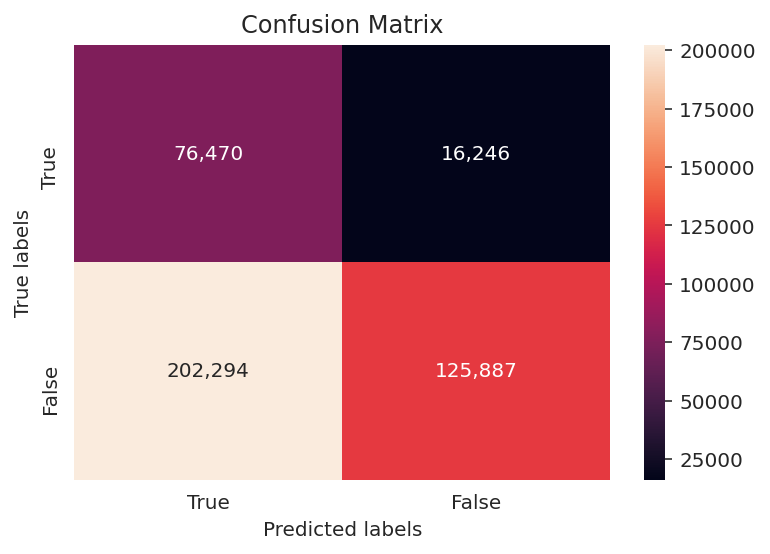

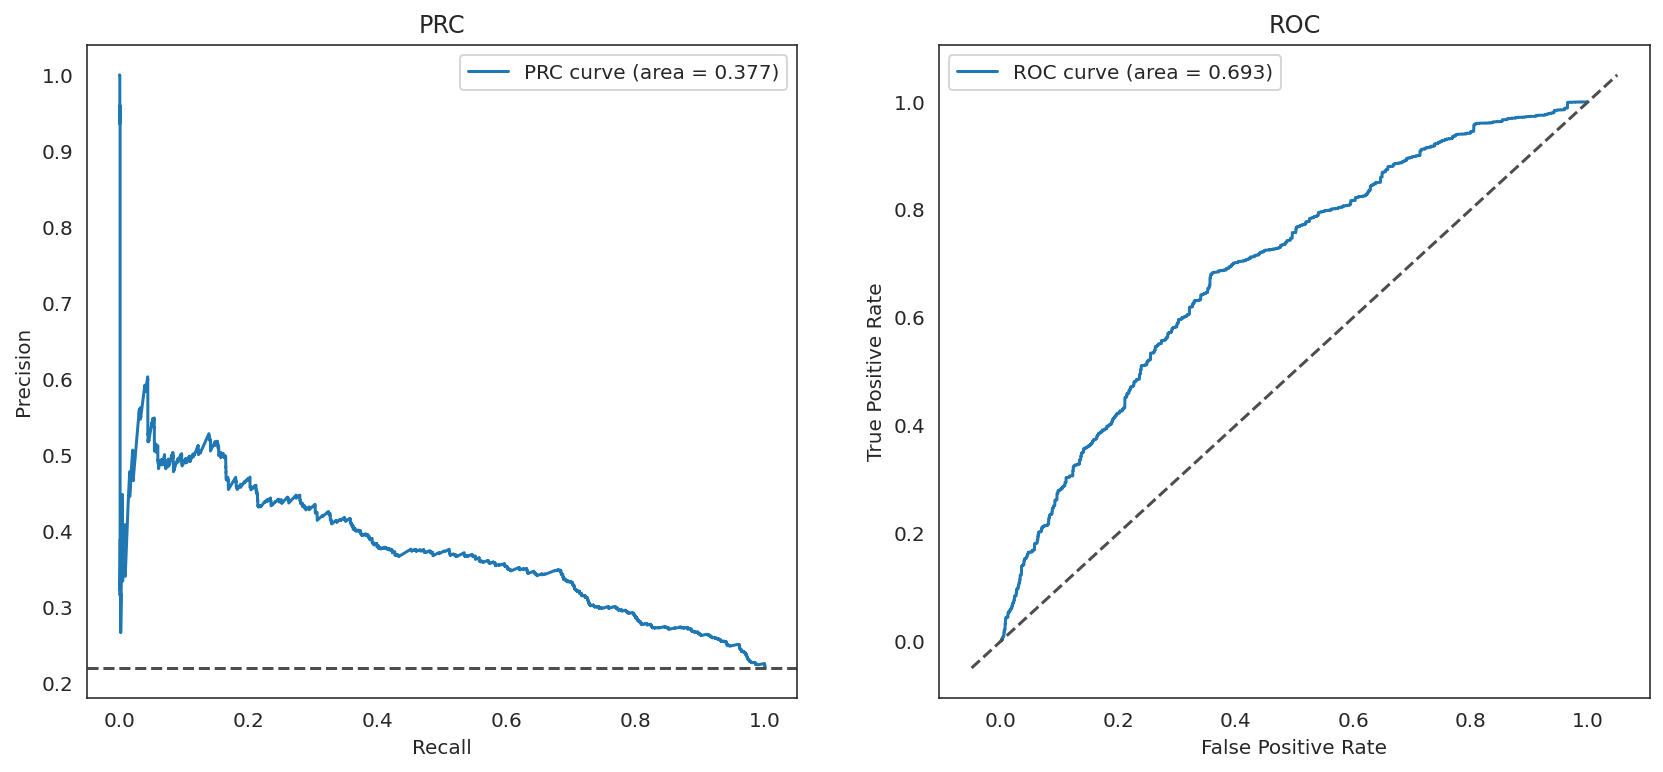

In [9]:
eval_models(y_valid, 'valid_balanced_heavy', heavy_models, sample_weights=valid_cluster_sizes)

### CDR3 - non-weighted

In [10]:
cdr3_models = models_from_dir('../../models/RoBERTa/mode_seq/subject_split_neg_subs/')
cdr3_models

['02_small_pretrained_2000epochs', '03_frozen_small_pretrained_2000epochs']

02_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.700
Accuracy: 0.695
MCC: 0.390
Recall: 0.710
FPR: 0.320




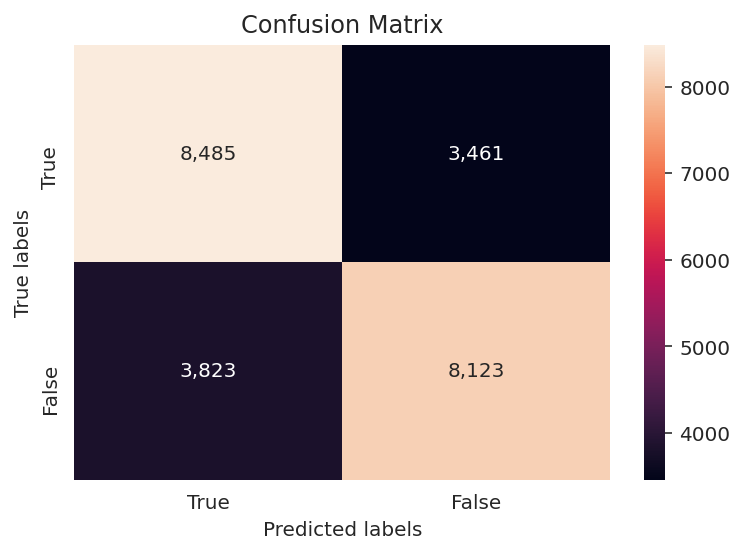

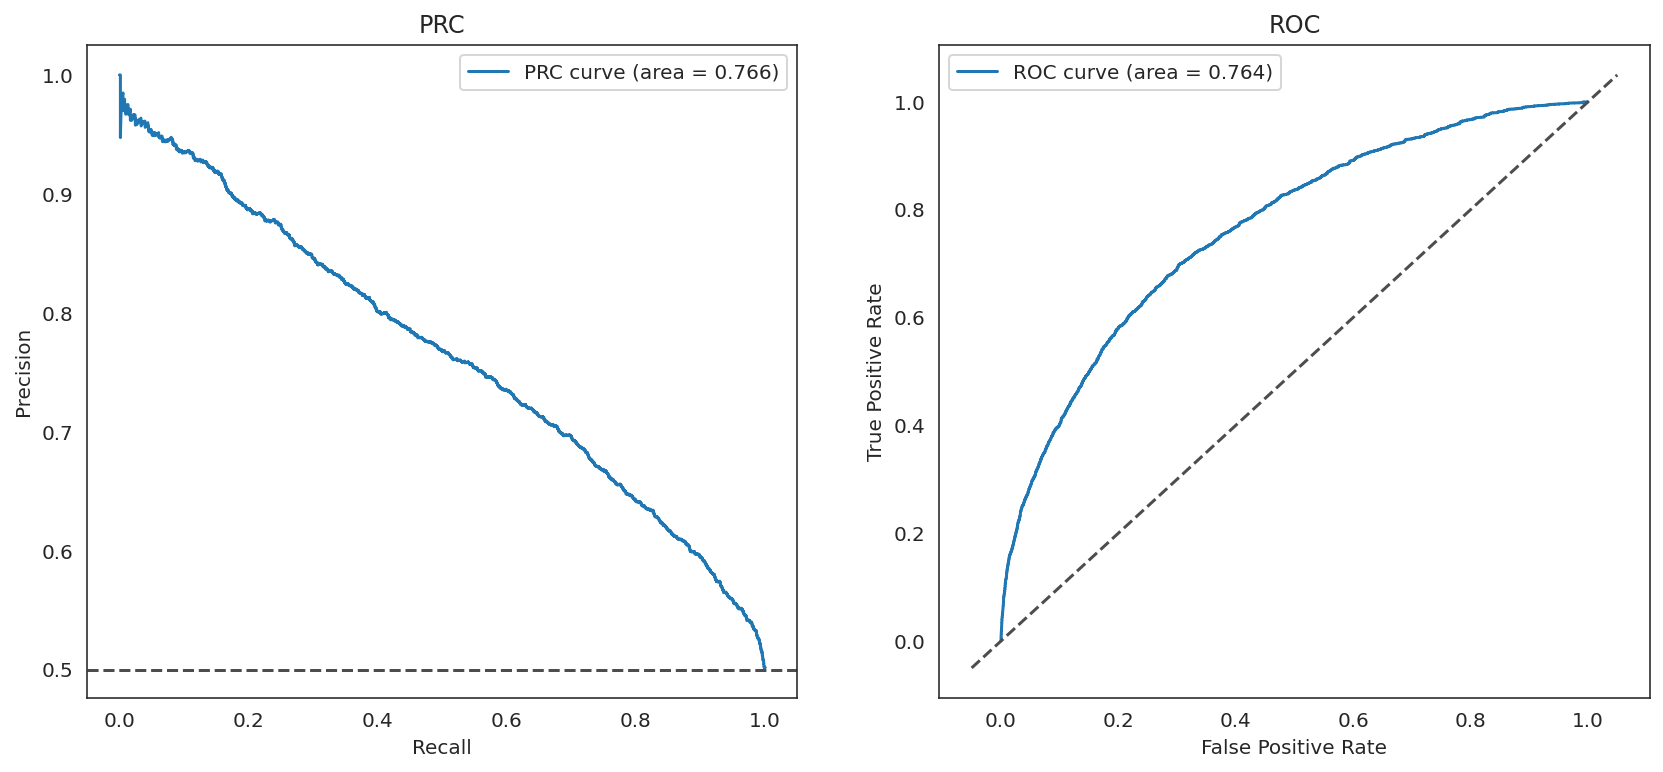

03_frozen_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.697
Accuracy: 0.683
MCC: 0.368
Recall: 0.728
FPR: 0.362




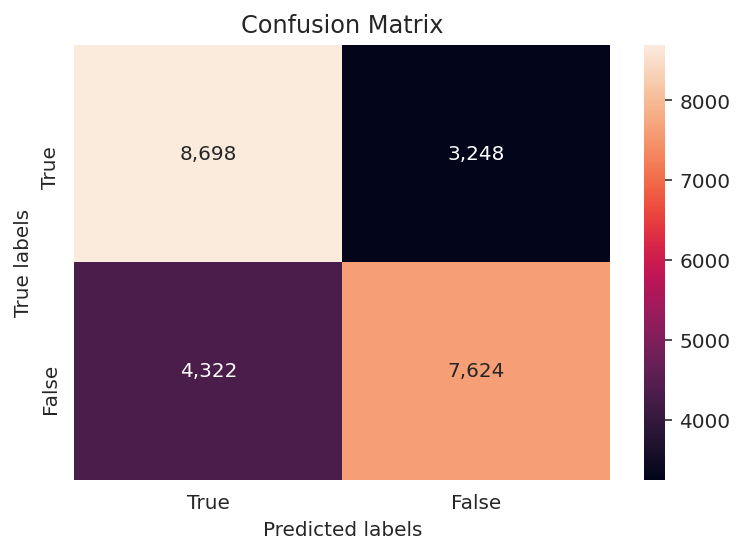

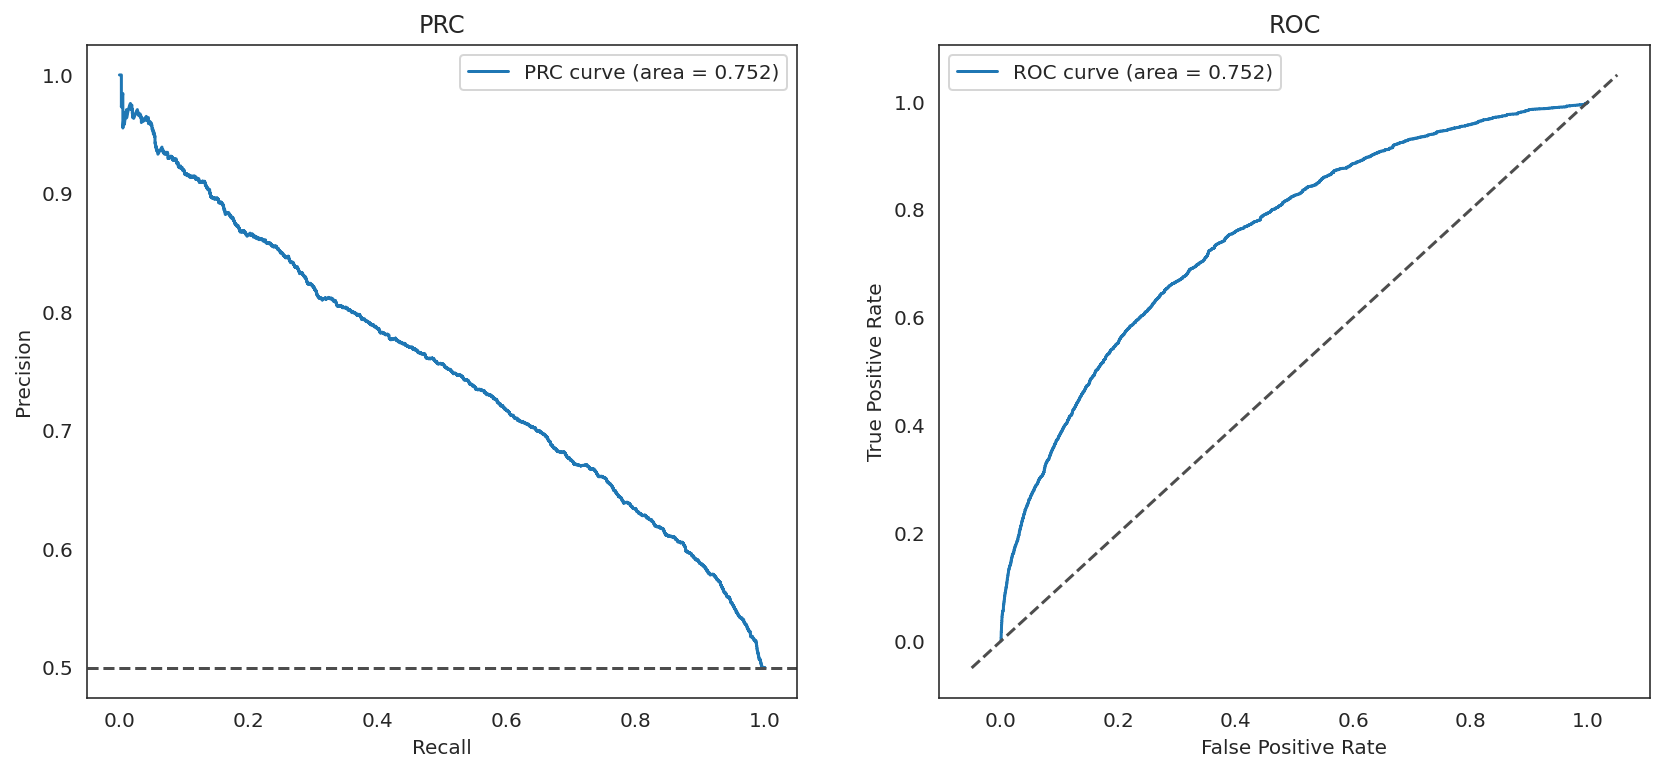

In [11]:
eval_models(y_valid, 'valid_balanced_cdr3', cdr3_models)

### CDR3 - weighted

02_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.396
Accuracy: 0.563
MCC: 0.156
Recall: 0.650
FPR: 0.462




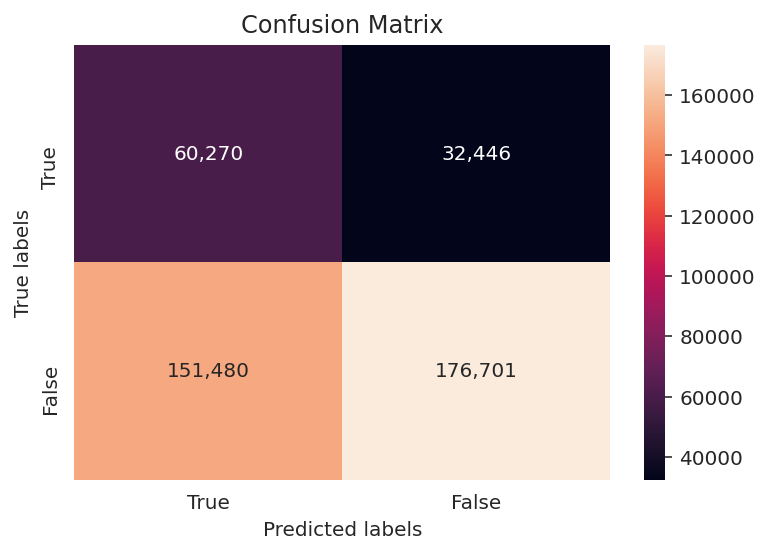

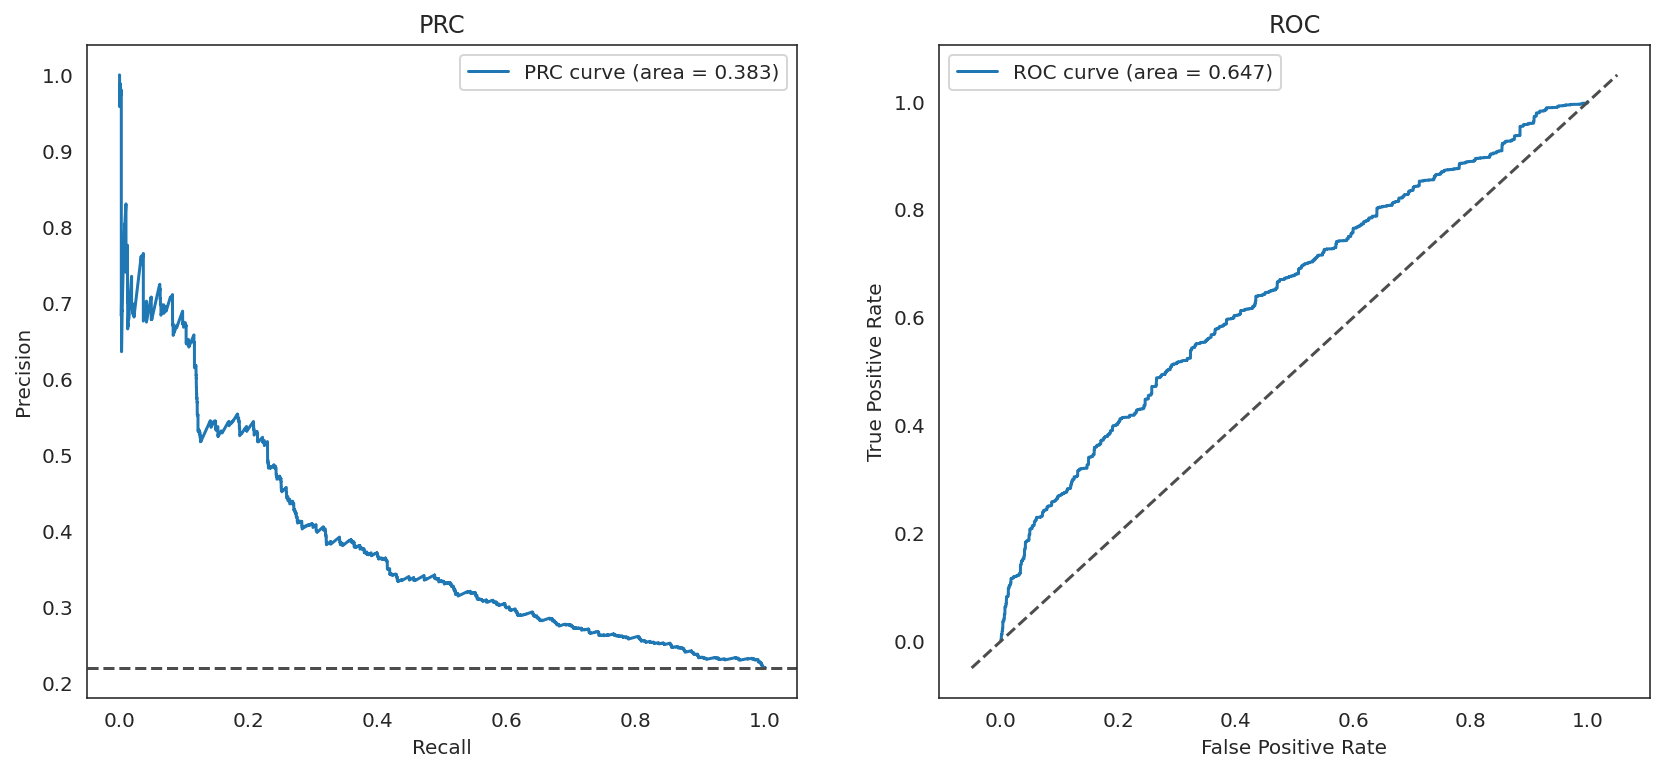

03_frozen_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.417
Accuracy: 0.570
MCC: 0.192
Recall: 0.698
FPR: 0.466




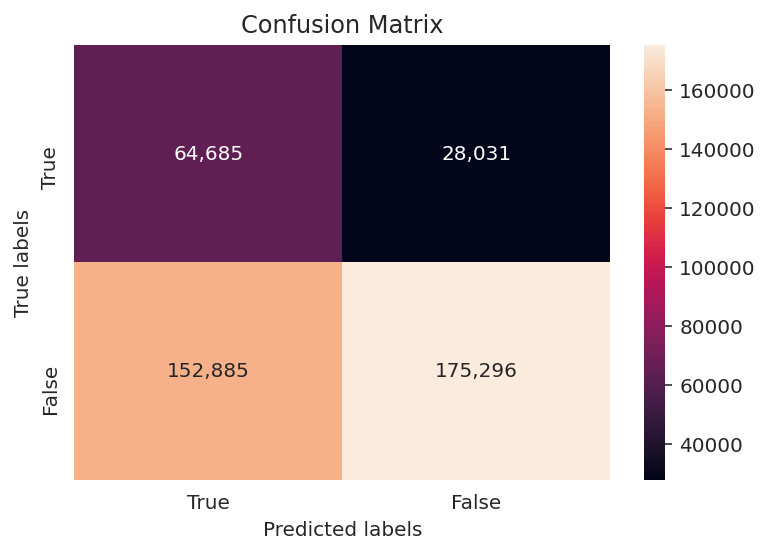

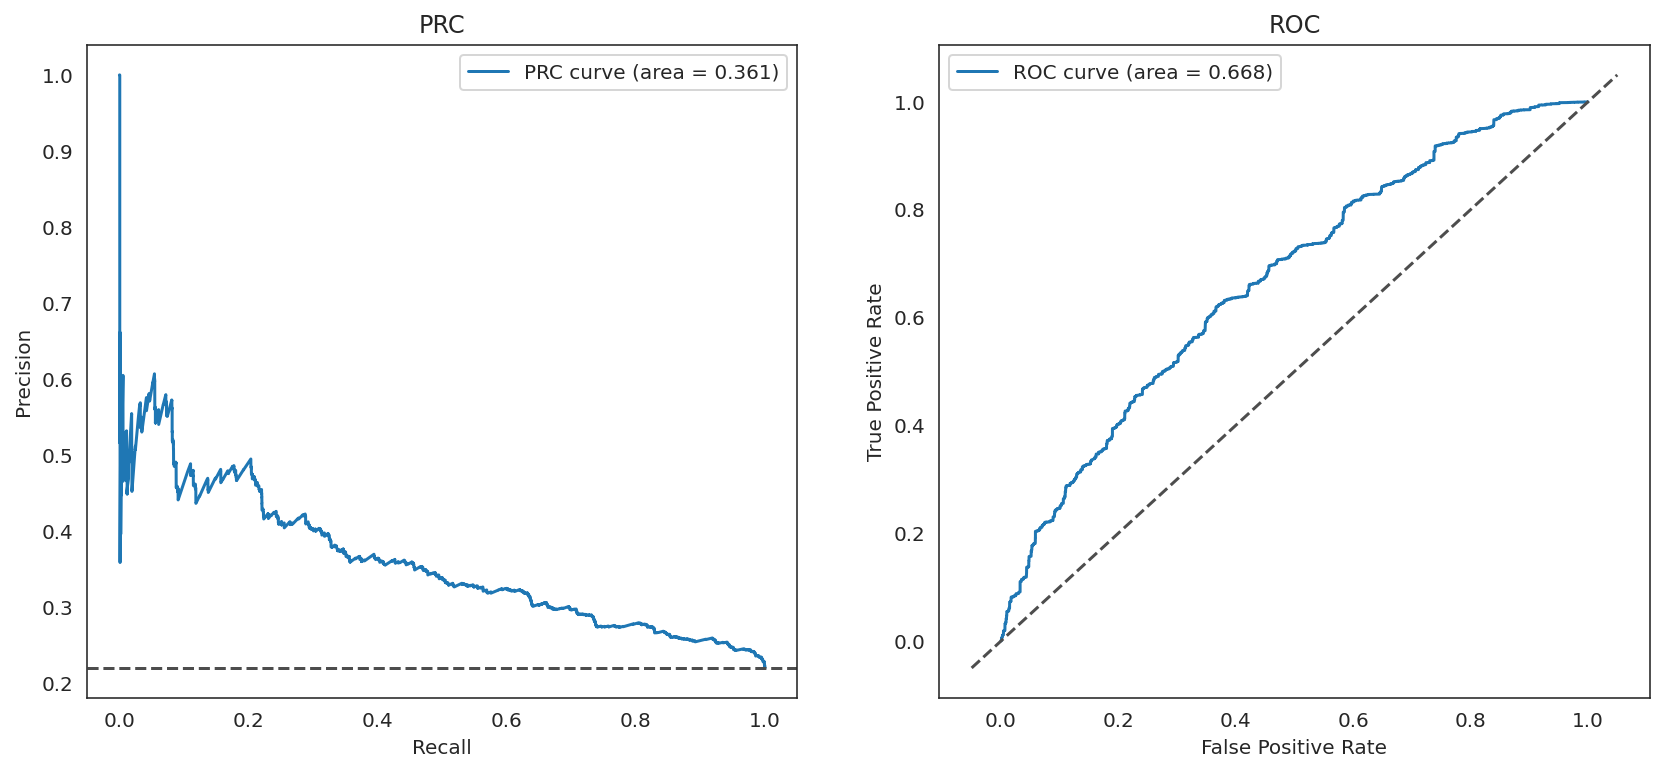

In [12]:
eval_models(y_valid, 'valid_balanced_cdr3', cdr3_models, sample_weights=valid_cluster_sizes)